# WordCloud作成

In [1]:
%matplotlib inline
import re
import unicodedata
from pathlib import Path

import MeCab
import matplotlib.pyplot as plt
import japanize_matplotlib # matplotlibの日本語化
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
from pathlib import Path
from itertools import chain

from dlsite_analyzer.database import SQLiteHandler, VoiceWorksViewHandler
from dlsite_analyzer.database.constants import VOICE_WORKS_TITLE, VOICE_WORKS_VIEW_AGE
from dlsite_analyzer.config import (
    DATABASE_PATH,
    MECAB_NEOLOGD_PATH,
    MECAB_USER_DIC_PATH
)

_NEO_TAGGER = MeCab.Tagger(f'-Owakati -d "{MECAB_NEOLOGD_PATH}" -u "{MECAB_USER_DIC_PATH}"')

def extract_and_count_words(dataframe, column, target_pos, stop_words):
    word_list = _extract_words(list(dataframe[column]), target_pos, stop_words)
    flattened_word_list = list(chain.from_iterable(word_list))
    word_count = pd.Series(flattened_word_list).value_counts()
    return word_count

def _extract_words(texts: list, target_pos=["名詞", "動詞", "形容詞"], stop_words: list=[]) -> list:
    '''
    テキストのリストから単語を抽出し、リストで返す
    
    Parameters
    ----------
    texts : list
        テキストのリスト
    target_pos : list
        抽出する品詞のリスト
    stop_words : list
        ストップワードのリスト
    
    Returns
    -------
    list
        抽出された単語のリスト
    '''
    documents = [_mecab_tokenizer(text, _NEO_TAGGER, target_pos, stop_words) for text in tqdm(texts)]
    return documents

def _mecab_tokenizer(text: str, mecab, target_pos=[], stop_words=[]) -> list:
    '''
    MeCabを用いてテキストを形態素解析し、指定した品詞の単語のリストを返す
    
    Parameters
    ----------
    text : str
        解析対象のテキスト
    mecab : MeCab.Tagger
        MeCabのTaggerオブジェクト
    target_pos : list
        抽出する品詞のリスト
    stop_words : list
        ストップワードのリスト
    
    Returns
    -------
    list
        解析結果の単語のリスト
    '''
    # テキストの前処理
    text = unicodedata.normalize("NFKC", text).upper()
    text = re.sub(r'[【】()（）『』「」]', '', text)  # 全角記号を削除
    text = re.sub(r'[\[\]［］]', ' ', text)  # 半角記号をスペースに変換

    # 形態素解析
    node = mecab.parseToNode(text)
    token_list = []
    # kana_re = re.compile("^[ぁ-ゖ]+$")  # ひらがなのみの正規表現

    while node:
        features = node.feature.split(',')
        pos = features[0]  # 品詞
        surface = node.surface

        # 指定の品詞かどうかをチェックし、条件に合致するものを追加
        if pos in target_pos and surface not in stop_words:
            token_list.append(surface)
        
        node = node.next

    return token_list

def generate_wordcloud(word_frequency_data: list | dict, font_path: str='ipaexg.ttf') -> WordCloud:
    '''
    語と出現回数のタプルのリストまたは辞書からワードクラウドを作成し、表示用のオブジェクトを返す。

    Parameters
    ----------
    word_frequency_data : list or dict
        語と出現回数のタプルのリストまたは辞書
    font_path : str, optional
        フォントのパス (デフォルトは 'ipaexg.ttf')
    Returns
    -------
    WordCloud
        作成されたWordCloudオブジェクト
    '''
    if isinstance(word_frequency_data, dict):
        wfdict = word_frequency_data
    else:
        wfdict = dict(word_frequency_data)
    
    wc = WordCloud(background_color='white', font_path=font_path, width=900, height=500)
    wc.generate_from_frequencies(wfdict)
    return wc

def plot_wordcloud(wordcloud_input: list | WordCloud, figsize=(15, 12), filename=None):
    '''
    ワードクラウドを表示し、オプションでファイルに保存する。

    Parameters
    ----------
    wordcloud_input : list or WordCloud
        単語のリストまたはWordCloudオブジェクト
    figsize : tuple, optional
        描画サイズ (デフォルトは (15, 12))
    filename : str, optional
        保存先のファイル名 (指定しない場合は保存しない)
    '''
    if isinstance(wordcloud_input, WordCloud):
        wc = wordcloud_input
    else:
        wc = generate_wordcloud(wordcloud_input)

    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [2]:
wordcloud_folder = Path('./data/wordcloud')

with SQLiteHandler(DATABASE_PATH) as db:
    voice_works_view_manager = VoiceWorksViewHandler(db)
    df = voice_works_view_manager.get_all_voice_works()

# 全年齢、R-15、R-18の作品データをフィルタリング
age_categories = ["全年齢", "R-15", "R-18"]
filtered_dfs = {age: df[df[VOICE_WORKS_VIEW_AGE] == age] for age in age_categories}

# 単語の抽出設定
target_pos = ["名詞", "動詞", "形容詞"]
stop_words = ['さ', 'し', 'せ', 'れ']

# 各カテゴリーの単語の出現回数を取得
word_counts = {
    "all": extract_and_count_words(df, VOICE_WORKS_TITLE, target_pos, stop_words),
    **{
        age: extract_and_count_words(filtered_dfs[age], VOICE_WORKS_TITLE, target_pos, stop_words)
        for age in age_categories
    }
}

# ワードクラウドの生成と保存
font_path = str(wordcloud_folder / 'ipaexg.ttf')
output_filenames = {
    "all": wordcloud_folder / "wordcloud_all.png",
    "全年齢": wordcloud_folder / "wordcloud_all_ages.png",
    "R-15": wordcloud_folder / "wordcloud_r15.png",
    "R-18": wordcloud_folder / "wordcloud_r18.png"
}

100%|██████████| 49633/49633 [00:01<00:00, 26329.91it/s]


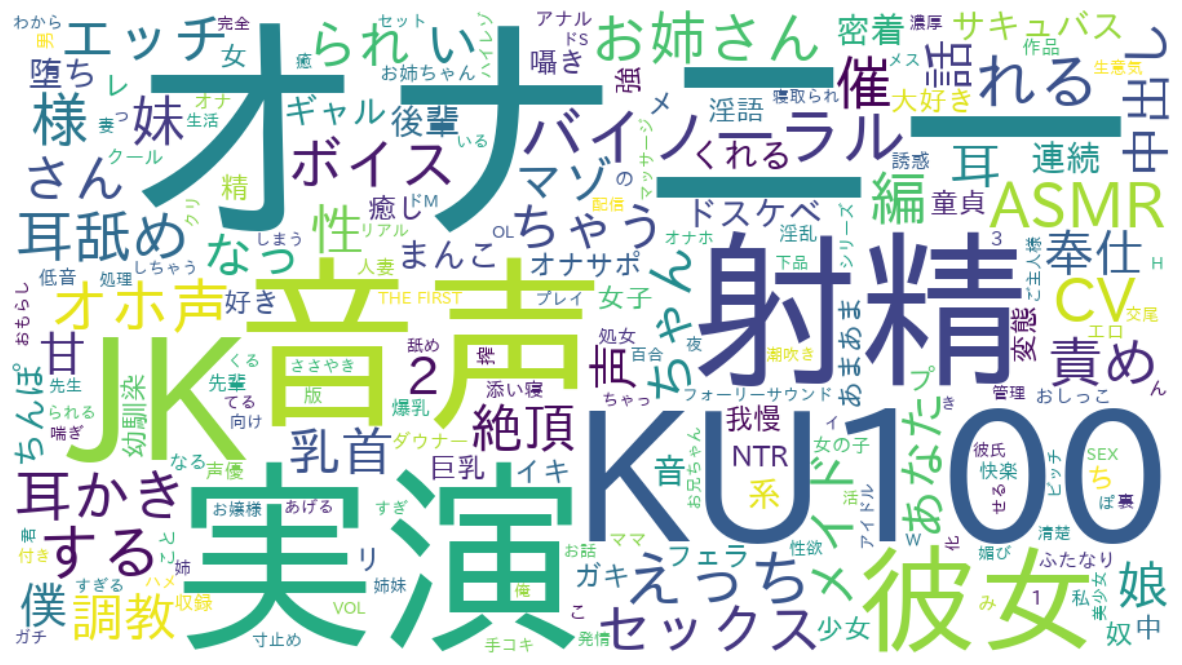

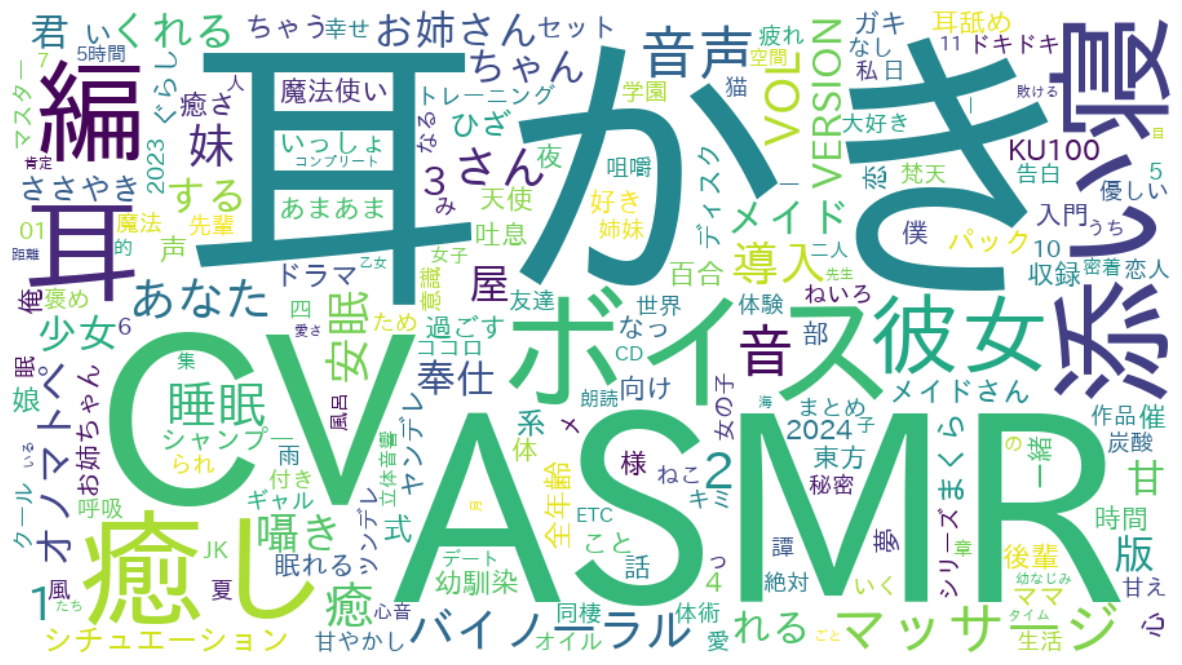

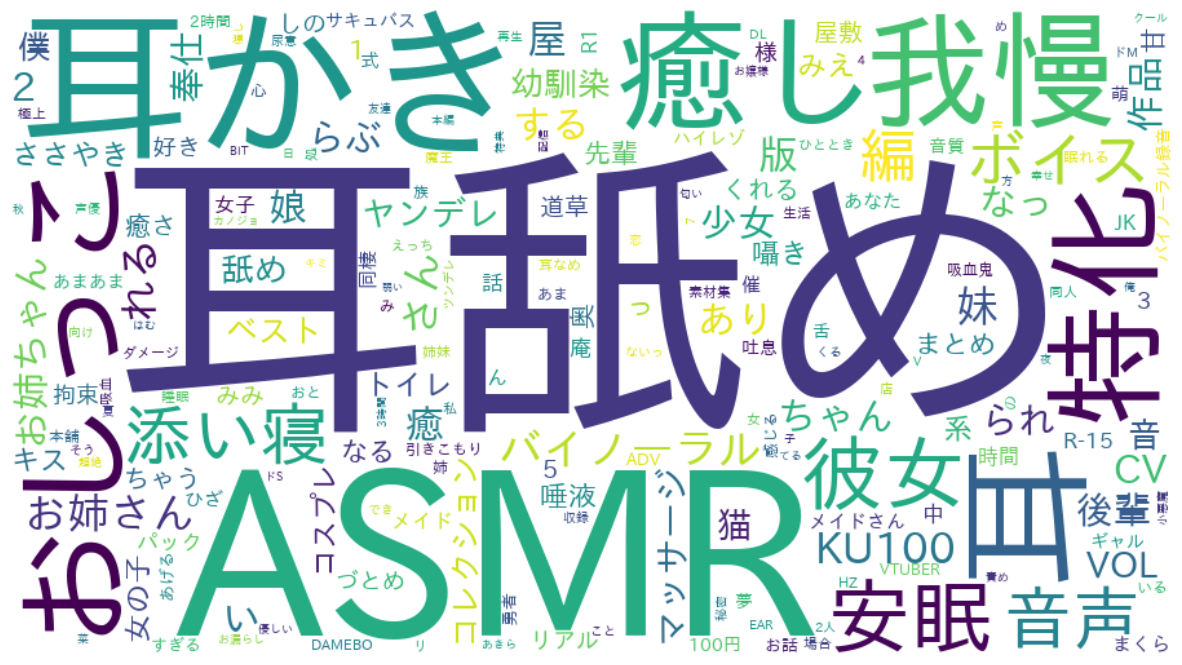

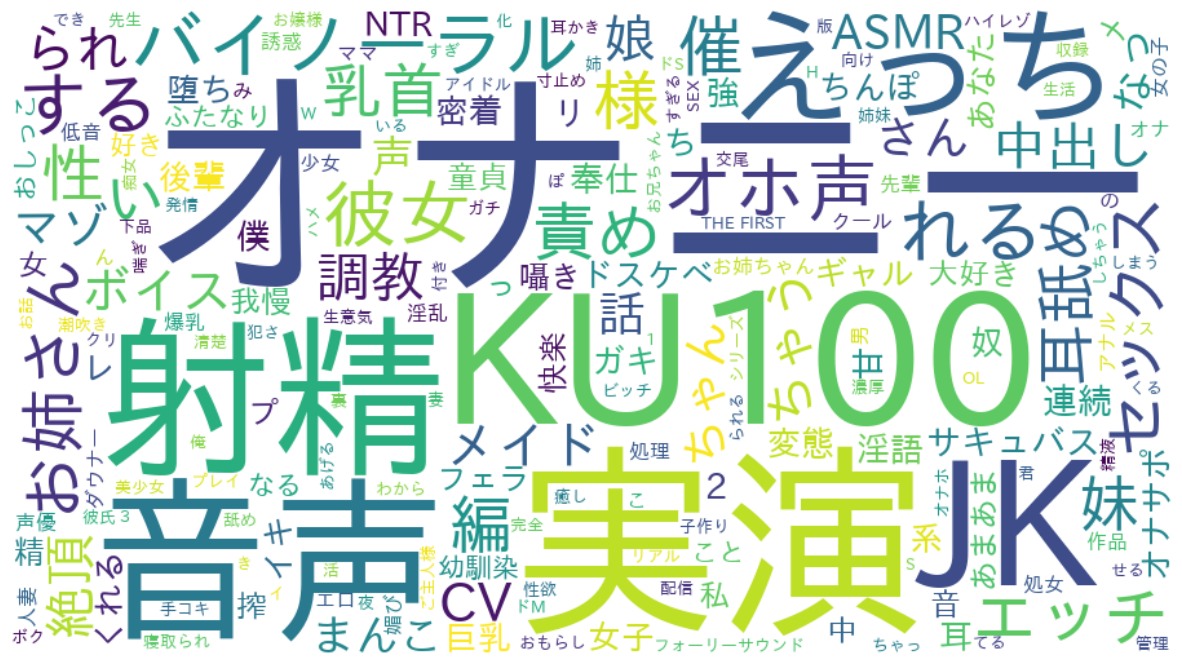

In [3]:
for category, word_count in word_counts.items():
    wc = generate_wordcloud(word_count, font_path=font_path)
    plot_wordcloud(wc, figsize=(15, 12), filename=output_filenames[category])